# Playing with Site Boundaries

Plotting raster with site boundary and state boundaries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import numpy as np
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import sys
from scipy import ndimage as ndi
import rasterio as rio
import subprocess, glob
%matplotlib inline 
#matplotlib widget

In [24]:
#Get site boundaries
gdf = gpd.read_file('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/Site Boundaries/terrestrialSamplingBoundaries.shp')

In [25]:
gdf = gdf.set_crs("EPSG:4326")

In [26]:
#Define my sites
sites = ("KONZ", "ORNL", "NIWO", "WREF", "BONA")
mysites = gdf['siteID'].isin(sites)
mysites_gdf = gdf[mysites]
mysites_gdf

,domainNumb,domainName,siteType,siteName,siteID,siteHost,areaKm2,acres,geometry
9,D06,Prairie Peninsula,Core Terrestrial,Konza Prairie Biological Station,KONZ,"The Nature Conservancy, Kansas State Universit...",34.868609,8616.186413,"POLYGON ((-96.61517 39.11102, -96.61467 39.111..."
23,D13,Southern Rockies & Colorado Plateau,Core Terrestrial,Niwot Ridge Mountain Research Station,NIWO,"University of Colorado at Boulder, U.S. Forest...",13.396032,3310.228579,"POLYGON ((-105.59906 40.05762, -105.59909 40.0..."
25,D16,Pacific Northwest,Core Terrestrial,Wind River Experimental Forest,WREF,U.S. Forest Service,41.939962,10363.581085,"MULTIPOLYGON (((-121.93193 45.79103, -121.9268..."
28,D19,Taiga,Core Terrestrial,Caribou-Poker Creeks Research Watershed,BONA,"University of Alaska, Fairbanks",13.929272,3441.984415,"POLYGON ((-147.43979 65.18076, -147.43979 65.1..."
51,D19,Taiga,Core Terrestrial,Caribou-Poker Creeks Research Watershed,BONA,Alaska Department of Natural Resources,35.703951,8822.638540,"POLYGON ((-147.43860 65.20415, -147.43979 65.1..."
55,D07,Appalachian & Cumberland Plateau,Core Terrestrial,Oak Ridge,ORNL,U.S. Department of Energy,57.371094,14176.693613,"MULTIPOLYGON (((-84.33263 35.90912, -84.33132 ..."


In [7]:
#Get states
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

In [8]:
#Get Washington state and sites
wa_gdf = states_gdf[states_gdf['NAME'] == 'Washington']
WREF = mysites_gdf[mysites_gdf['siteID'] == 'WREF']

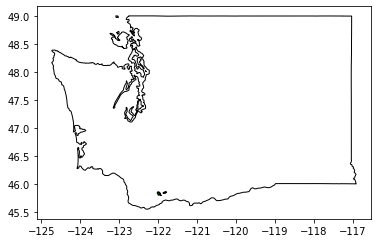

In [9]:
#Plot site on map of Washingotn 
f, ax = plt.subplots()
wa_gdf.plot(ax=ax, facecolor='none', edgecolor='k');
WREF.plot(ax=ax, facecolor='green', edgecolor='k');

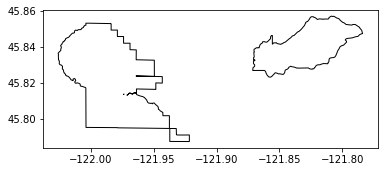

In [11]:
#Plot WA site
f, ax = plt.subplots()
WREF.plot(ax=ax, facecolor='none', edgecolor='k');

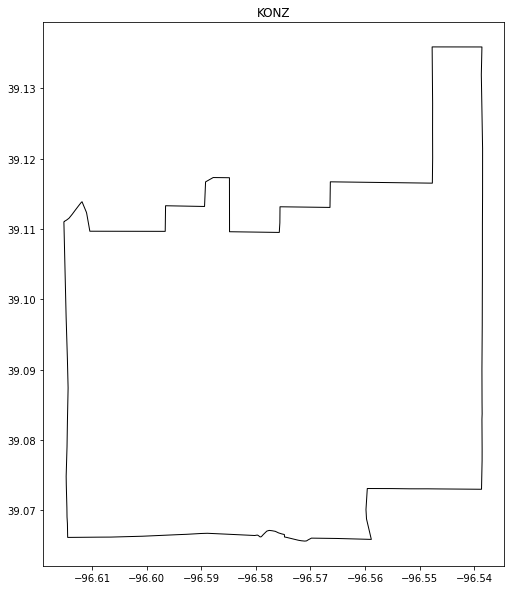

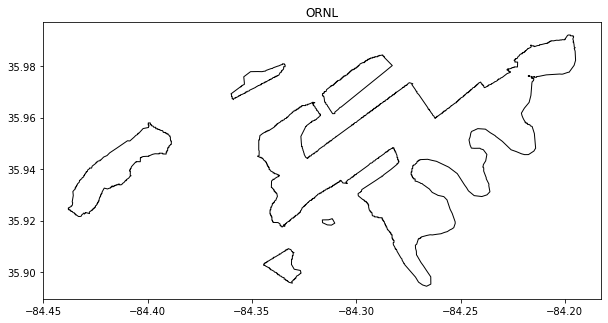

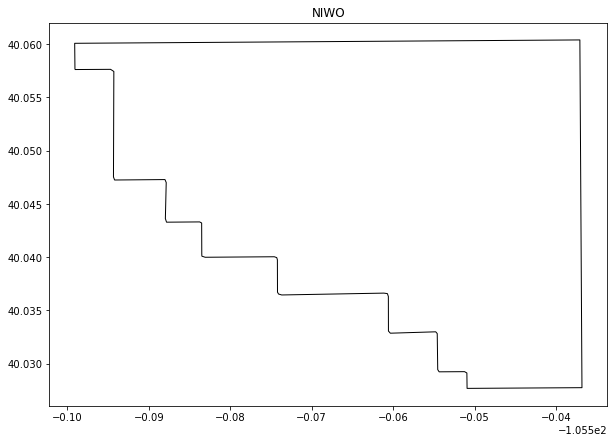

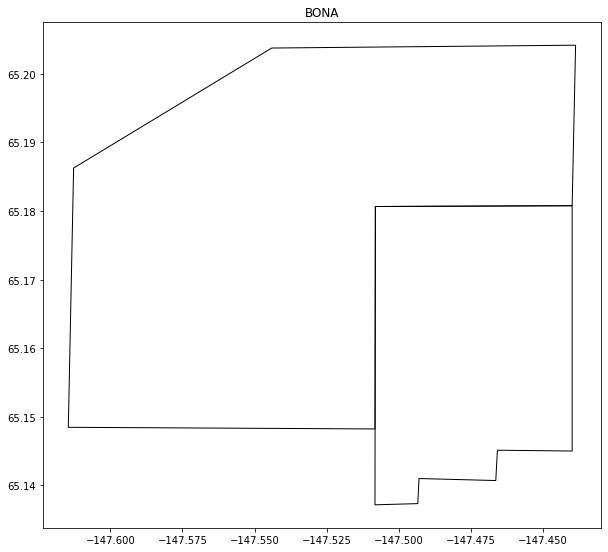

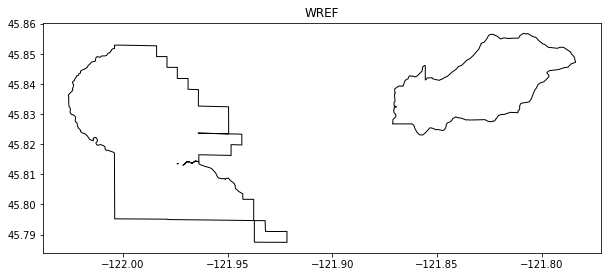

In [26]:
#Plot each site 
site_list = ("KONZ", "ORNL", "NIWO", "BONA","WREF")

for site in site_list:
    site_map = mysites_gdf[mysites_gdf['siteID'] == site]
    f, ax = plt.subplots(figsize=(10,10))
    ax.set_title(site)
    site_map.plot(ax=ax, facecolor='none', edgecolor='k');

#### Plotting a raster with a specified site

In [77]:
chm_file = '/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/Combined_Mosaic_WREF.tif'

In [78]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

#Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)

#Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

#Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

In [79]:
#Define array
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

<ipython-input-79-62963efe515c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)


In [135]:
#Define plot band array function

def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

<ipython-input-152-a19465a70aaf>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)


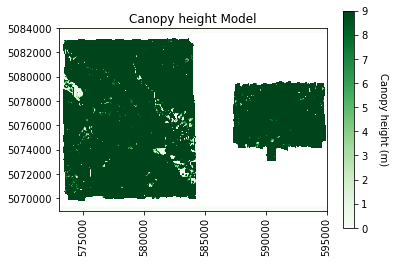

In [152]:
#Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

#PLot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, 9])

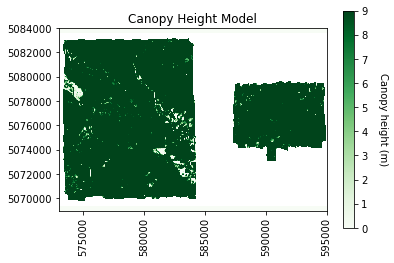

In [80]:
plt.imshow(chm_array,extent=image_extent)
cbar = plt.colorbar(); plt.set_cmap('Greens'); plt.clim([0,9])
cbar.set_label('Canopy height (m)',rotation=270,labelpad=20)
plt.title("Canopy Height Model"); ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain') 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [55]:
prj = chm_dataset.GetProjection()
prj

'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]'

In [81]:
WREF_proj = WREF.to_crs("EPSG:32610")

In [82]:
wa_extent_x = (WREF_proj.total_bounds[0], WREF_proj.total_bounds[2])
wa_extent_y = (WREF_proj.total_bounds[1], WREF_proj.total_bounds[3]) 

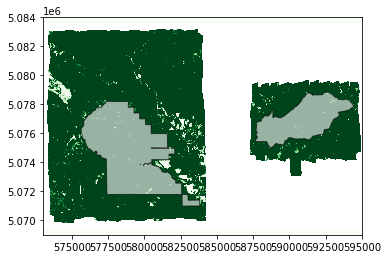

In [83]:
f, ax = plt.subplots()
ax.imshow(chm_array, extent = image_extent, cmap = 'Greens', vmin=0, vmax=9);
ax = plt.gca()
WREF_proj.plot(ax=ax, facecolor = 'white', edgecolor = "black", alpha = 0.6);
#plt.xlim(wa_extent_x);
#plt.ylim(wa_extent_y);

### Combine all rasters

Combine rasters for each site into one for analysis

In [38]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
from osgeo import osr

In [9]:
#URLS for each site: 
KONZ_path = '/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/DP3.30015.001/2019/2019_KONZ_4/CanopyHeightModelGtif'
ONRL_path = "NA"
NIWO_path = '/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/DP3.30015.001/2019/2019_NIWO_3/CanopyHeightModelGtif'
BONA_path = '/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/DP3.30015.001/2019/2019_BONA_3/CanopyHeightModelGtif'
WREF_path = '/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/DP3.30015.001/2019/2019_WREF_4/CanopyHeightModelGtif'

In [16]:
site_list = ("KONZ", "NIWO", "BONA","WREF")

In [10]:
dirpath = KONZ_path
search_criteria = "*.tif"
q = os.path.join(dirpath, search_criteria)

In [11]:
dem_fps = glob.glob(q)

In [12]:
src_files_to_mosaic = []
for fp in dem_fps:
   src = rasterio.open(fp)
   src_files_to_mosaic.append(src)

In [13]:
mosaic, out_trans = merge(src_files_to_mosaic)

In [14]:
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": out_trans,
                "crs": out_meta['crs']
                }
                )

In [17]:
out_fp = os.path.join('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/Combined_Mosaic_' + site_list[0] + ".tif")
out_fp

'/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/Combined_Mosaic_KONZ.tif'

In [18]:
with rasterio.open(out_fp, "w", **out_meta) as dest:
           dest.write(mosaic)

### Plotting each site 

In [88]:
site_list

('KONZ', 'NIWO', 'BONA', 'WREF')

In [51]:
d = gdal.Open('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/Combined_Mosaic_KONZ.tif')
proj = osr.SpatialReference(wkt=d.GetProjection())
proj = proj.GetAttrValue('AUTHORITY',1)
'ESPG:' + proj

'ESPG:32614'

In [55]:
dis = {}
extent = {}
proj_list = {}
for site in site_list:
    #Open the CHM file with GDAL
    chm_dataset = gdal.Open(os.path.join('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/Combined_Mosaic_' + site +'.tif'))
    #Get projection 
    proj = osr.SpatialReference(wkt=chm_dataset.GetProjection())
    proj = proj.GetAttrValue('AUTHORITY',1)
    proj_list[site] = 'EPSG:' + proj
    
    #Get the raster band object
    chm_raster = chm_dataset.GetRasterBand(1)

    #Get the NO DATA value
    noDataVal_chm = chm_raster.GetNoDataValue()

    #Get required metadata from CHM file
    cols_chm = chm_dataset.RasterXSize
    rows_chm = chm_dataset.RasterYSize
    bands_chm = chm_dataset.RasterCount
    mapinfo_chm =chm_dataset.GetGeoTransform()
    xMin = mapinfo_chm[0]
    yMax = mapinfo_chm[3]
    xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
    yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
    extent[site] = (xMin,xMax,yMin,yMax)

    #Define array
    combined_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)
    
    dis[site] = combined_array

<ipython-input-55-01ec56aeb7c5>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combined_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)


In [56]:
proj_list

{'KONZ': 'EPSG:32614',
 'NIWO': 'EPSG:32613',
 'BONA': 'EPSG:32606',
 'WREF': 'EPSG:32610'}

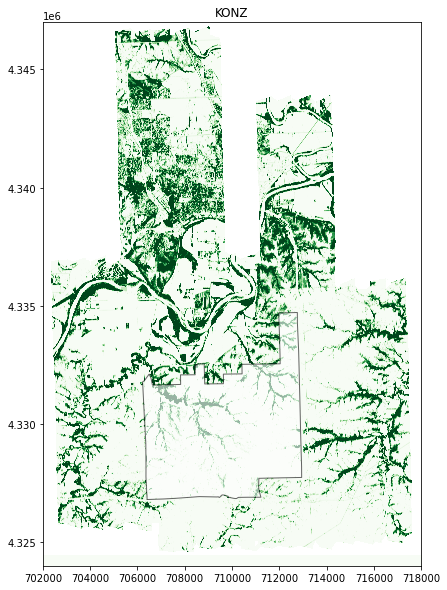

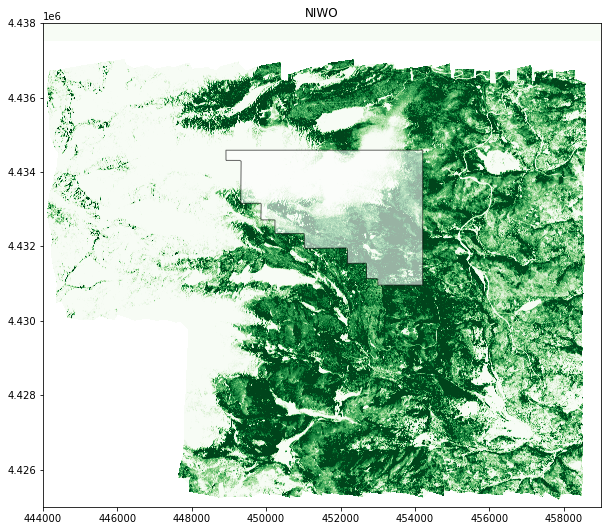

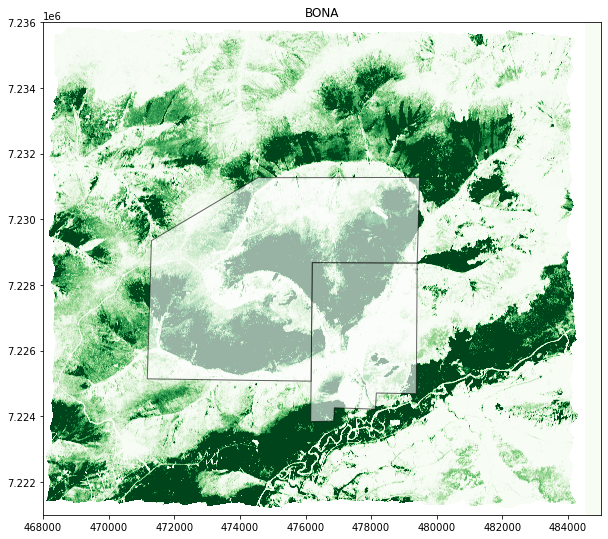

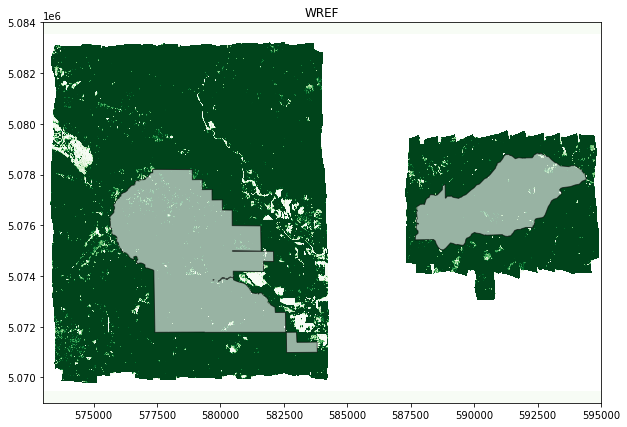

In [59]:
#Plot each site 

for site in site_list:
    site_map = mysites_gdf[mysites_gdf['siteID'] == site]
    site_map = site_map.to_crs(proj_list[site])
    f, ax = plt.subplots(figsize=(10,10))
    ax.set_title(site)
    site_map.plot(ax=ax, facecolor='white', edgecolor='black', alpha = 0.6);
    ax.imshow(dis[site], extent = extent[site], cmap = 'Greens', vmin=0, vmax=9);
    ax = plt.gca();